# Mounting google drive : 
The trained model weights will be saved here.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Train and test data loaders

In [2]:
! pip install albumentations==0.4.6

In [3]:
import torch
import torchvision
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from data_loader import get_train_test_data_loaders
batch_size = 512
train_loader, test_loader, classes = get_train_test_data_loaders(random_seed=1,batch_size =batch_size)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer   car horse   dog


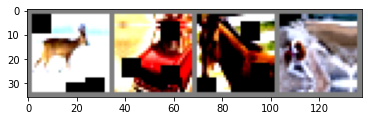

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
from resnet_new import myResNetNew
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("device: ",device)
model = myResNetNew().to(device)

device:  cuda


In [6]:
from torchsummary import summary
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         ConvBlock-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]         147,456
       BatchNorm2d-8          [-1, 128, 16, 16]             256
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
         ResBlock-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]         294,912
        MaxPool2d-13            [-1, 256, 8, 8]               0
      BatchNorm2d-14            [-1, 25

In [9]:
len(train_loader)
len(train_loader.dataset)

50000

# Finding the min and max learning rates for One Cycle Policy

In [8]:
from lr_range_test import run_learning_rate_range_test
import torch.nn as nn

model = myResNetNew().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.95, weight_decay=1e-4)

Min loss: 2.10016982511722
LR for min loss: 0.09312626067333


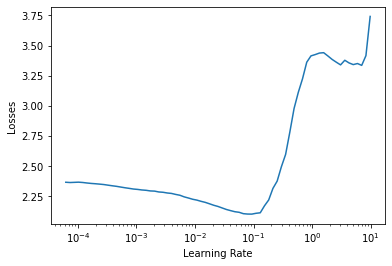

In [9]:
run_learning_rate_range_test(model, criterion, optimizer,
                                 train_loader, device)

The loss is min at lr =0.0931 .   
The max lr for OCP will be one power higher than the above lr.   
So we choose 0.931 as the max lr for OCP.

# Training the model

In [7]:
from cifar10_trainer import fit
from OneCycle import OneCycle
import torch.nn as nn


model = myResNetNew().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.95, weight_decay=1e-4)
number_of_epochs = 24
bs=512

onecycle = OneCycle(
    int(len(train_loader.dataset) * number_of_epochs/bs),
    0.931,
    prcnt=0,
    momentum_vals=(0.95, 0.8)
)
train_stats, test_stats = fit(
    num_epochs=24,
    use_onecycle=False,
    onecycle=onecycle,
    model=model,
    device="cuda",
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=test_loader
)

Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc


/content/cifar10_trainer.py:127: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  var_ip = Variable(input, volatile=True)
/content/cifar10_trainer.py:128: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  var_tg = Variable(target, volatile=True)


1	2.14709873	2.05052635	19.97399902	21.09666634
2	1.95141205	1.86161365	24.84454536	25.56833267
3	1.82227705	1.72652905	28.12529373	28.69888878
4	1.72545755	1.63257080	30.61913109	31.07166672
5	1.65349513	1.55927041	32.61862183	32.98533249
6	1.59739709	1.50619316	34.31485748	34.62111282
7	1.54294410	1.45528919	35.76170731	36.03428650
8	1.50203836	1.41194077	37.03765869	37.28395844
9	1.47542513	1.38166489	38.20169830	38.42036819
10	1.43359267	1.34242516	39.26525497	39.46400070
11	1.39955969	1.31081683	40.23830795	40.42515182
12	1.37391470	1.29071057	41.14168930	41.30486298
13	1.34476875	1.25221476	41.99142838	42.15705109
14	1.31591265	1.22288280	42.80638504	42.96416473
15	1.28998402	1.20305927	43.57854080	43.72244644
16	1.26265649	1.18028828	44.31336594	44.45500183
17	1.23479457	1.15417003	45.02227783	45.15323639
18	1.21652391	1.13229763	45.68934631	45.81657410
19	1.19788916	1.11937448	46.33557510	46.45482254
20	1.17756724	1.09381308	46.95042038	47.06391525
21	1.15466935	1.07738529	47.5